<center>
<h1 style="font-family: Tahoma, sans-serif;">
<span style="color: #0078D7;">Project: K Nearest Neighbors</span>
</h1>

<h3>
Introduction to Machine Learning<br>
MSc in Computer Science - Machine Learning and Data Mining<br>
Faculty of Sciences and Techniques<br>
Université Jean Monnet
</h3>

<h2><span style="color: #0078D7;">Team Members</span></h2>
<h3>Chelsy Mena & Serhii Vakulenko</h3>
<center>

<h1 style="font-family: Tahoma, sans-serif;">
  <span style="color: #0078D7;">0 | </span>Notebook Set Up
</h1>

In [1]:
#%% LIBRARIES USED
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import time

import warnings
warnings.filterwarnings("ignore")

# Setting Seaborn style
sns.set_theme(
    style="darkgrid", 
    rc={
		"axes.facecolor": "#fcfcfc",
        "grid.color": "#605e5e",
        "axes.edgecolor": "#605e5e",
        "text.color": "#4d4d4d",
        "xtick.color": "#605e5e",
        "ytick.color": "#605e5e"
    }
)

palette = ["#8E44AD", "#3498DB", "#1ABC9C", "#F1C40F", "#E67E22", "#E74C3C"]
np.random.shuffle(palette)

sns.set_palette(palette)

# Setting a default figure size
plt.rcParams["figure.figsize"] = (12, 6)

<h1 style="font-family: Tahoma, sans-serif;">
  <span style="color: #0078D7;">1 | </span>Exploratory Data Analysis
</h1>

In [2]:
#%% LOAD DATA
data = np.genfromtxt('Files\waveform.data',	delimiter=',')

We have a dataset with 5000 observations for 21 features and one label. Here we can see our data is fairly balanced as well 

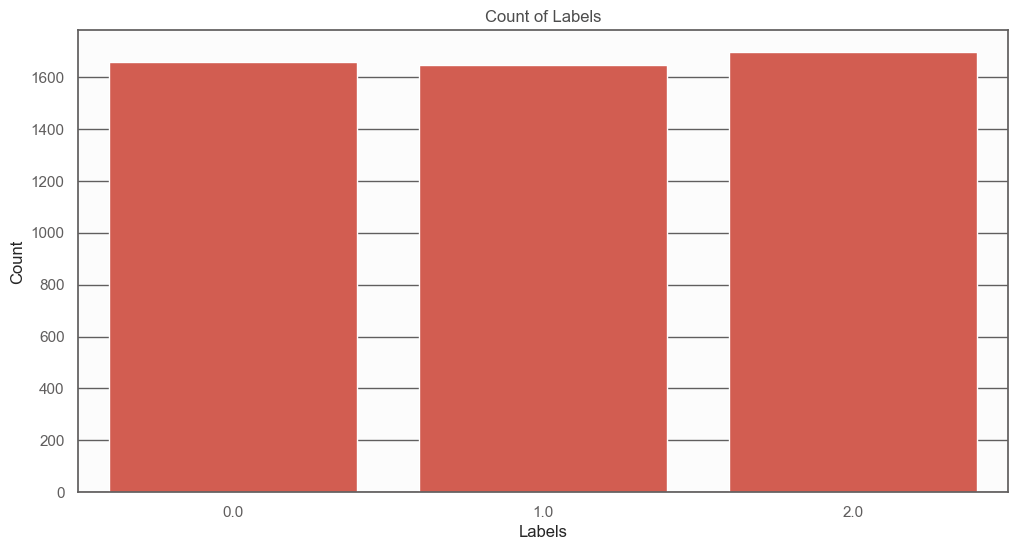

In [3]:
unique, counts = np.unique(data[:,21], return_counts=True)
sns.barplot(x=unique, y=counts)
plt.title("Count of Labels")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()

Initially, we want to see some pairs of features to understand if the data is easily visualized as is. We select alleatorilly some of the features and plot them in 2D spaces below:

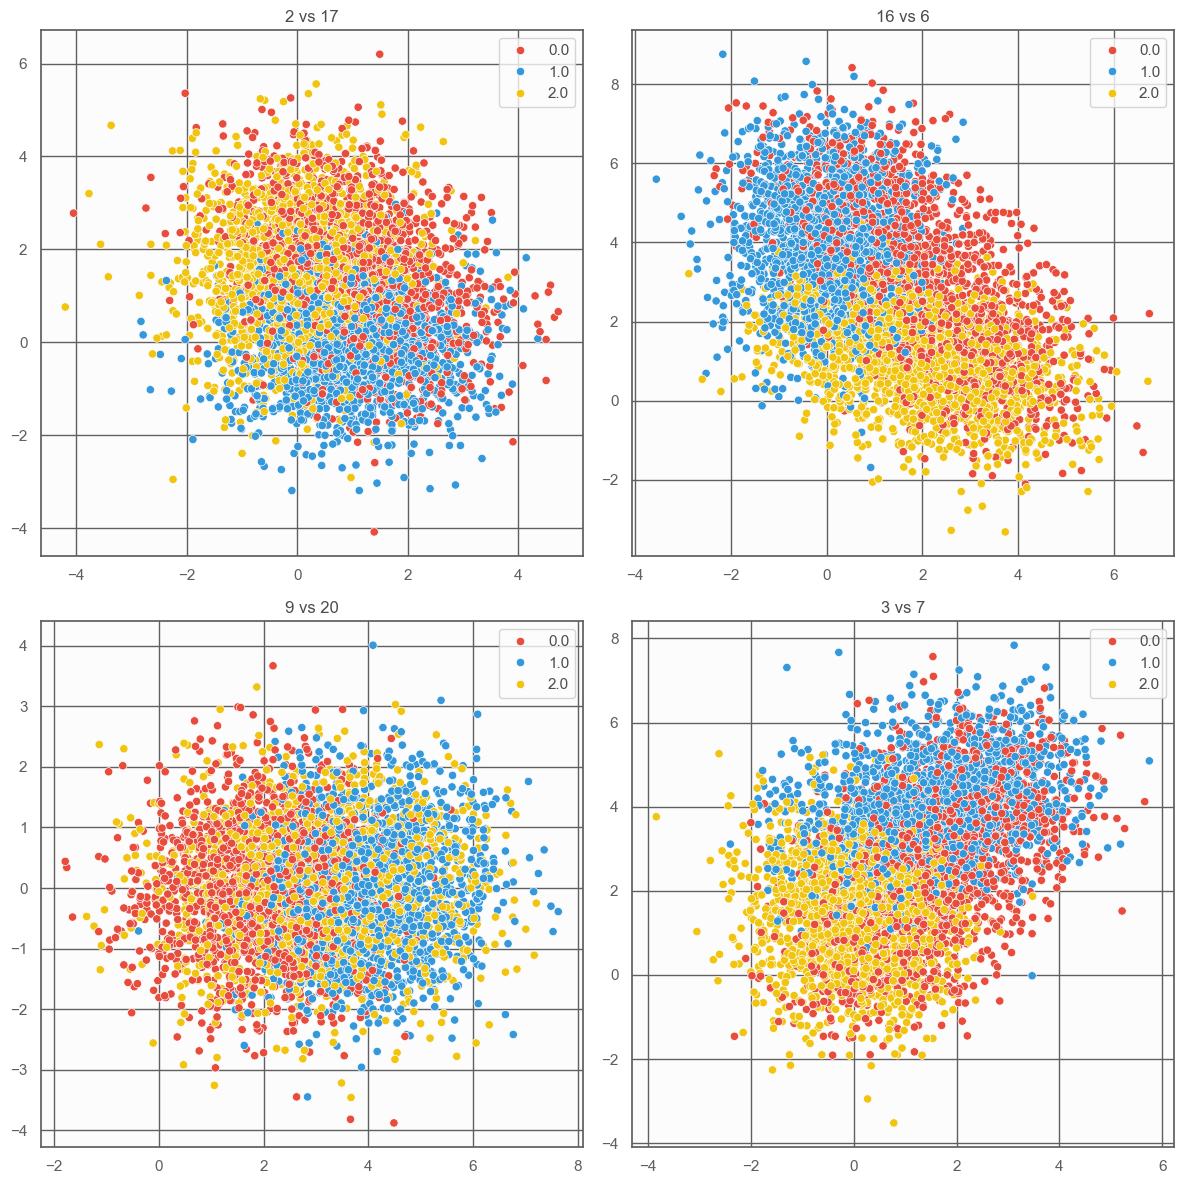

In [4]:
pairs = []
for i in range(4):
    x = np.random.randint(0, data.shape[1]-1)
    y = np.random.randint(0, data.shape[1]-1)
    pairs.append((x, y))

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()
for i, (x, y) in enumerate(pairs):
    x_data = data[:, x]
    y_data = data[:, y]
    sns.scatterplot(x=x_data, y=y_data, ax=axes[i], hue=data[:,21],palette=palette)
    axes[i].set_title(f"{x} vs {y}")
plt.tight_layout()
plt.show()

We can also see that the features behave reasonably close to a normal distribution by plotting Q-Q plots for each feature, the red line being the quartiles of the standarized data:

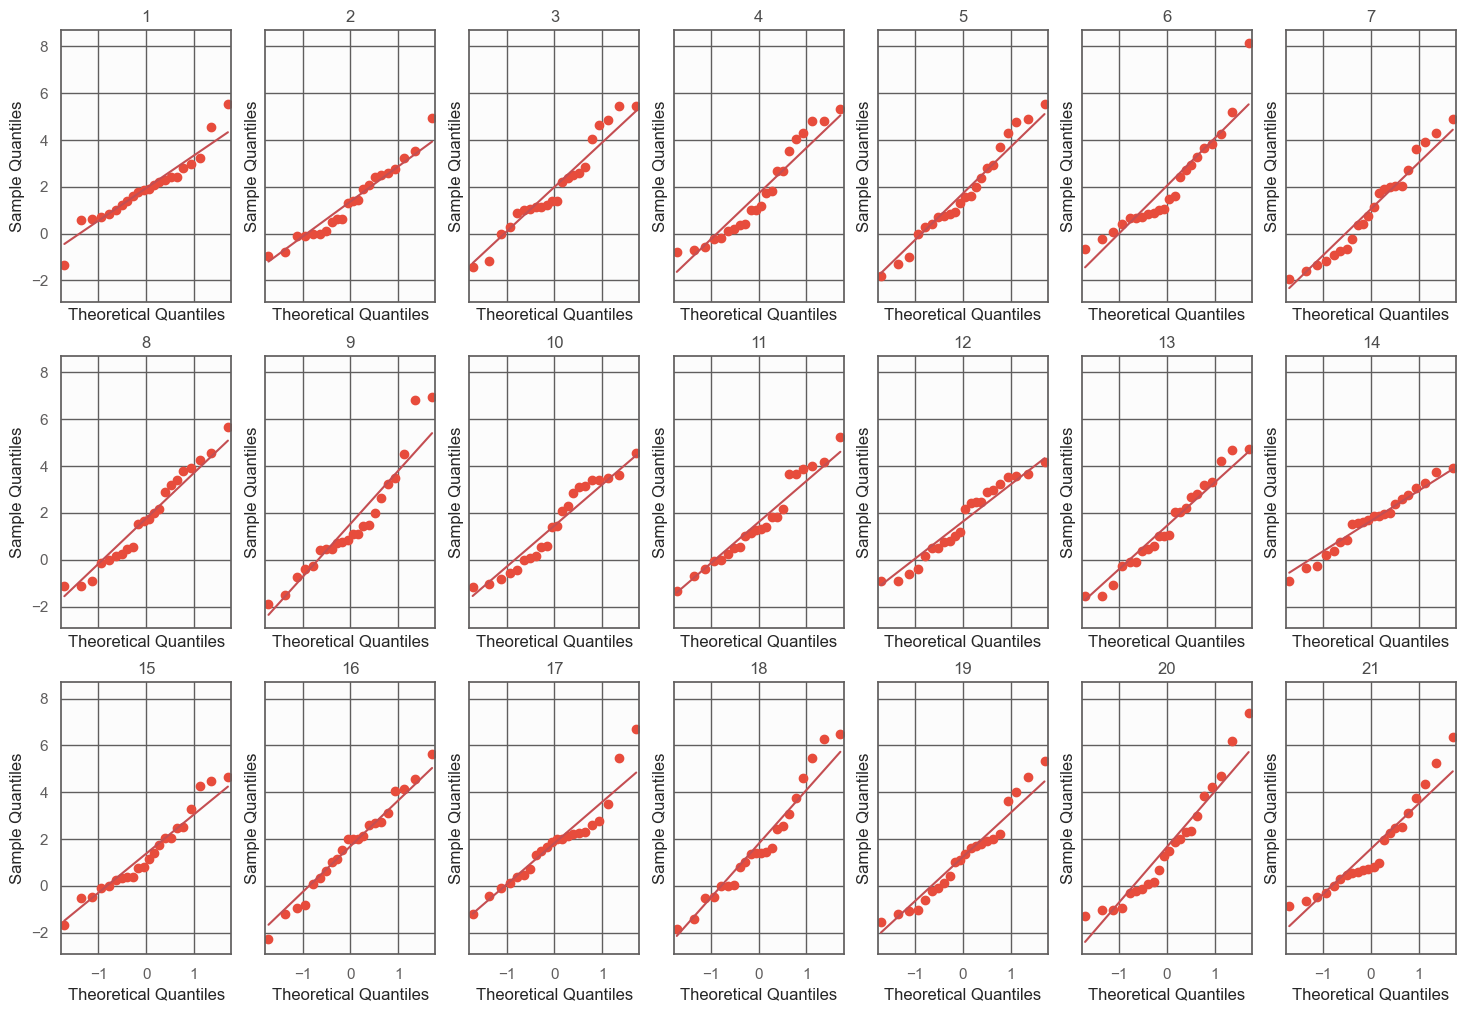

In [5]:
fig, axes = plt.subplots(3, 7, figsize=(18, 12), sharex=True, sharey=True)

column = 0
for i in range(3):
    for j in range(7):
        sm.qqplot(data[column+1], line='s', ax=axes[i][j])
        axes[i][j].set_title(str(column+1))
        column +=1
plt.show()

And we can see that the mean of the features ranges between 1 and a little over 2, and the standard deviations as well.

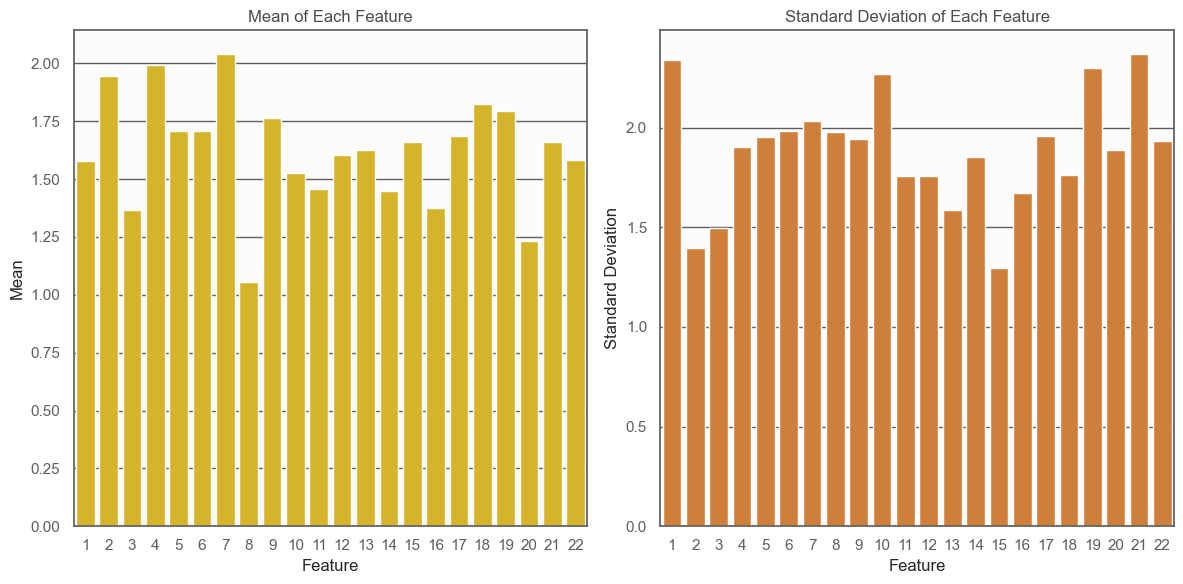

In [6]:
means = [np.mean(data[i]) for i in range(data.shape[1])]
stdevs = [np.std(data[i]) for i in range(data.shape[1])]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(x=list(range(1, len(means)+1)), y=means, ax=axes[0], color=palette[2])
axes[0].set_title("Mean of Each Feature")
axes[0].set_xlabel("Feature")
axes[0].set_ylabel("Mean")

sns.barplot(x=list(range(1, len(stdevs)+1)), y=stdevs, ax=axes[1], color=palette[3])
axes[1].set_title("Standard Deviation of Each Feature")
axes[1].set_xlabel("Feature")
axes[1].set_ylabel("Standard Deviation")

plt.tight_layout()
plt.show()

<h1 style="font-family: Tahoma, sans-serif;">
  <span style="color: #0078D7;">2 | </span>K Nearest Neighbor Model Training
</h1>

<h2 style="font-family: Tahoma, sans-serif;">
  <span style="color: #0078D7;">2.1 | </span>Selecting k: k-fold Cross Validation
</h2>

We will be using one fifth of the dataset for the model training, leaving 1000 observations as our final validation set.

Over the 4000 observations used for training we will run a k-fold validation to pick the best value for the hyperparameter k, number of neighbors. 

For this process we define the following functions:

In [7]:
def split_data(data, n):
	"""
	Split data in two groups, one with n elements and another with the rest
	
	Input: numpy array dataset, dims a x b
	Output: two numpy arrays, dims b x n and b x (b-n)
	"""

	if n >= data.shape[0]:
		raise IndexError("The dataset has less examples than you think man. Pick a smaller n.")

	np.random.seed(13)
	n_index = list(np.random.choice(data.shape[0], 1000, replace=False))
	remaining_index = [x for x in list(range(data.shape[0])) if x not in n_index]

	n_data = data[n_index]
	remaining_data = data[remaining_index]

	return n_data, remaining_data

def euclidian_distance(point_a, point_b):

	"""
	Calculate the Euclidian Distance for two points
	
	Input: Two points, numpy arrays
	Output: The distance between the two points
	"""

	diffs = 0

	for i in range(point_a.shape[0]):
		diffs += (point_a[i] - point_b[i])**2
	distance = diffs**0.5

	return float(distance)


def distance_matrix(train_data, test_data):

	"""
	Precalculate the distance matrix between two tables
	
	Input: Two numpy arrays with points
	Output: Distance matrix between the two, numpy array
		Each row the distances between a test point and every point in train
	"""
	
	distance_matrix = []

	for test_point in test_data:
		row = []
		for train_point in train_data:
			distance = euclidian_distance(test_point, train_point)
			row.append(distance)
		distance_matrix.append(row)

	return np.array(distance_matrix)


def knn(features_data, point_to_predict, labels_data, k, distance_matrix=None, point_to_predict_index = None):

	"""Predict the labels for a dataset
	
	Input: 
		- Train dataset, numpy array
		- Point predict, numpy array
		- Number of neighbors to consider
		- Distance matrix if it's precalculated outside
	
	Output: 
		- Chosen label
	"""

	#If I precalculated the distances, just need to get the row
	if distance_matrix is not None:
		distances_array = distance_matrix[point_to_predict_index] #Aqui el lio es, sabes que fila de la precalculada es?
		distances = []
		for x in range(len(features_data)):
			distances.append((distances_array[x],float(labels_data[x]))) 
	# Else, calculate all distances and store them
	else:
		distances = []
		for x in range(len(features_data)):
			distances.append((euclidian_distance(features_data[x], point_to_predict), float(labels_data[x])))

	# Pick the indexes of the k nearest neighbors
	k_nearest_neighbors = sorted(distances, key=lambda x: x[0])[:k]


	class_weights = {}
	for distance, class_label in k_nearest_neighbors:
		weight = 1 / distance if distance != 0 else 0
		if class_label in class_weights:
			class_weights[class_label] += weight
		else:
			class_weights[class_label] = weight
	
	predicted_label = int(max(class_weights, key=class_weights.get))

	return predicted_label

def model_accuracy(predicted_labels, test_labels):

	"""Calculate the accuracy of a prediction
	
	Input: 
		- Predicted Labels, list
		- True labels, list
	
	Output: 
		- Accuracy over the predictions, float
	"""

	correct_predictions = 0
	for i in range(len(test_labels)):
		if predicted_labels[i] == test_labels[i]:
			correct_predictions += 1
	
	acc = float(correct_predictions / len(test_labels))
	
	return acc

def custom_k_fold(train_data, n_folds=3, k_range=(1, 100)):
    
	total_points = train_data.shape[0]
	n_items_fold = int(total_points/n_folds)

	accuracies = []
	variances = []

	for i in range(1, n_folds+1):

		# Split the small validation data
		val_index = list(range((i-1)*n_items_fold, i*n_items_fold))
		train_index = [x for x in list(range(total_points)) if x not in val_index]

		fold_train = train_data[train_index]
		fold_test = train_data[val_index]

		calculated_distance_matrix = distance_matrix(
			fold_train[:, :-1], fold_test[:, :-1])

		X = fold_train[:, :-1]
		y = fold_train[:, -1]

		accs = []
		for k in range(k_range[0], k_range[1]):

			preds = []
			for i in range(len(fold_test)):

				pred = knn(
					features_data=X,
					point_to_predict=fold_test[i, :-1],
					labels_data=y,
					k=k,
					distance_matrix=calculated_distance_matrix,
					point_to_predict_index = i)
				preds.append(pred)
				
			acc = model_accuracy(preds, fold_test[:, -1])
			accs.append(acc)
	
		accuracies.append(accs)
	
	accuracies = np.array(accuracies)
	avg_accuracies = []
	variances = []
	for j in range(k_range[1]-1):
		avg_accuracy = np.mean(accuracies[:, j])
		avg_accuracies.append(avg_accuracy)

		variance = np.var(accuracies[:, j])
		variances.append(variance)

	return avg_accuracies, variances

We begin by separating 20% of the data for our testing:

In [8]:
#Keep apart 1000 data points for the test set
test_data, train_data = split_data(data, n=1000)

print(f"Data Size: {data.shape[0]} x {data.shape[1]}")
print(f"Test Size: {test_data.shape[0]} x {test_data.shape[1]}")
print(f"Train Size: {train_data.shape[0]} x {train_data.shape[1]}")

Data Size: 5000 x 22
Test Size: 1000 x 22
Train Size: 4000 x 22


To select our best k, we will run several cycles of k-fold cross-validation, and test for each of them neighbors between 1 and 100. To make the process faster, we will precalculat the distances between the points on our validation fold and the remainig training data; since in each fold these don't change when the number of neighbors does.

In [9]:
n_splits_values = [3, 4, 5, 10]
accuracies = {n_splits: [] for n_splits in n_splits_values}

best_k_per_split = {}
best_accuracies = []
variances_table = []

for n_splits in n_splits_values:

    avg_accuracies, variances = custom_k_fold(train_data, n_folds=n_splits, k_range=(1, 101))
    
    # To plot
    accuracies[n_splits] = avg_accuracies
    
    # To Evaluate
    best_accuracy = max(avg_accuracies)
    best_k = avg_accuracies.index(best_accuracy)+1
    best_k_per_split[n_splits] = best_k
    best_accuracies.append((n_splits, best_k, best_accuracy))

    variances_table.append((n_splits, np.mean(variances)))


Best Average Accuracy Table:
   n_splits  Best k  Best Average Accuracy
0         3      37                0.84196
1         4      34                0.84425
2         5      47                0.85000
3        10      50                0.84450

Variance Table:
   n_splits  Variance
0         3  0.000218
1         4  0.000212
2         5  0.000103
3        10  0.000549


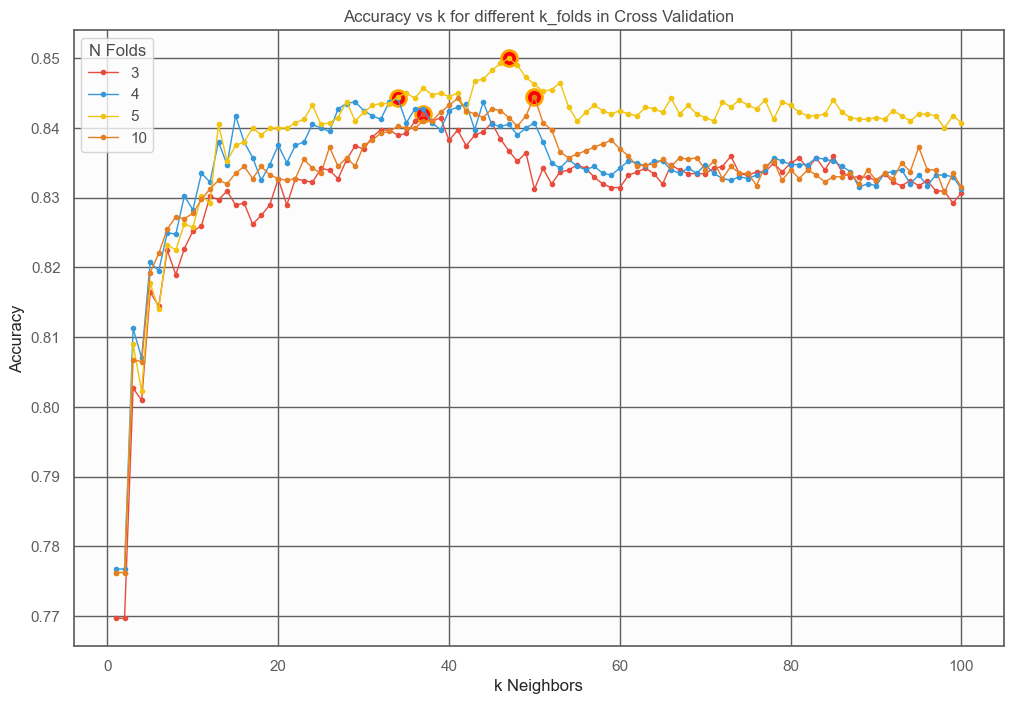

In [10]:
# Creating tables for best average accuracy, true risk accuracy, and variances
best_avg_accuracy_table = pd.DataFrame(best_accuracies, columns=['n_splits', 'Best k', 'Best Average Accuracy'])
variance_table = pd.DataFrame(variances_table, columns=['n_splits', 'Variance'])

print("\nBest Average Accuracy Table:")
print(best_avg_accuracy_table)

print("\nVariance Table:")
print(variance_table)

# Plotting cross-validation accuracies
plt.figure(figsize=(12, 8))
for n_splits in n_splits_values:
    plt.plot(list(range(1,101)), accuracies[n_splits], label=f'{n_splits}', linestyle='-', marker='o', markersize=3, linewidth=1)

# Highlighting best points for each n_fold training
for n_splits, best_k, best_accuracy in best_accuracies:
    plt.scatter(best_k, best_accuracy, color='red', marker='o', s=130, edgecolor='orange', linewidth=2)

plt.xlabel('k Neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k for different k_folds in Cross Validation')
plt.legend(title="N Folds")
plt.grid(True)
plt.show()

<h2 style="font-family: Tahoma, sans-serif;">
  <span style="color: #0078D7;">2.2 | </span>Data Reduction Techniques
</h2>

We define the following functions to reduce the number of datapoints in our dataset, and use them consequently

In [11]:
def bayesian_region(data):

	index_split = np.random.randint(0, data.shape[0])
	S1 = data[: index_split]
	S2 = data[index_split+1:]

	missclassified = []
	for i in range(len(S1)):
		pred = knn(S2[:,:-1], S1[i, :-1], S2[:,-1], k=1)
		if pred != int(S1[i, -1]):
			missclassified.append(i)
	keep = [x for x in list(range(len(S1))) if x not in missclassified]
	S1 = S1[keep]

	# Now backwards
	missclassified = []
	for i in range(len(S2)):
		pred = knn(S1[:,:-1], S2[i, :-1], S1[:,-1], k=1)
		if pred != int(S2[i, -1]):
			missclassified.append(i)
	keep = [x for x in list(range(len(S2))) if x not in missclassified]
	S2 = S2[keep]

	kept_data = np.vstack((S1, S2))

	return kept_data

def condensed(data):

	storage = [np.random.randint(0, data.shape[0])]
	dustbin = []

	for point in range(data.shape[0]):

		# Predict the point with the data in storage
		pred = knn(data[storage, :-1], data[point, :-1], data[storage, -1], k=1)

		if pred == int(data[point, -1]):
			dustbin.append(point)
		else:
			storage.append(point)
	
	return data[storage]

In [12]:
step_one = bayesian_region(train_data)
step_two = condensed(step_one)


We can see here how the data's density changes for each step:

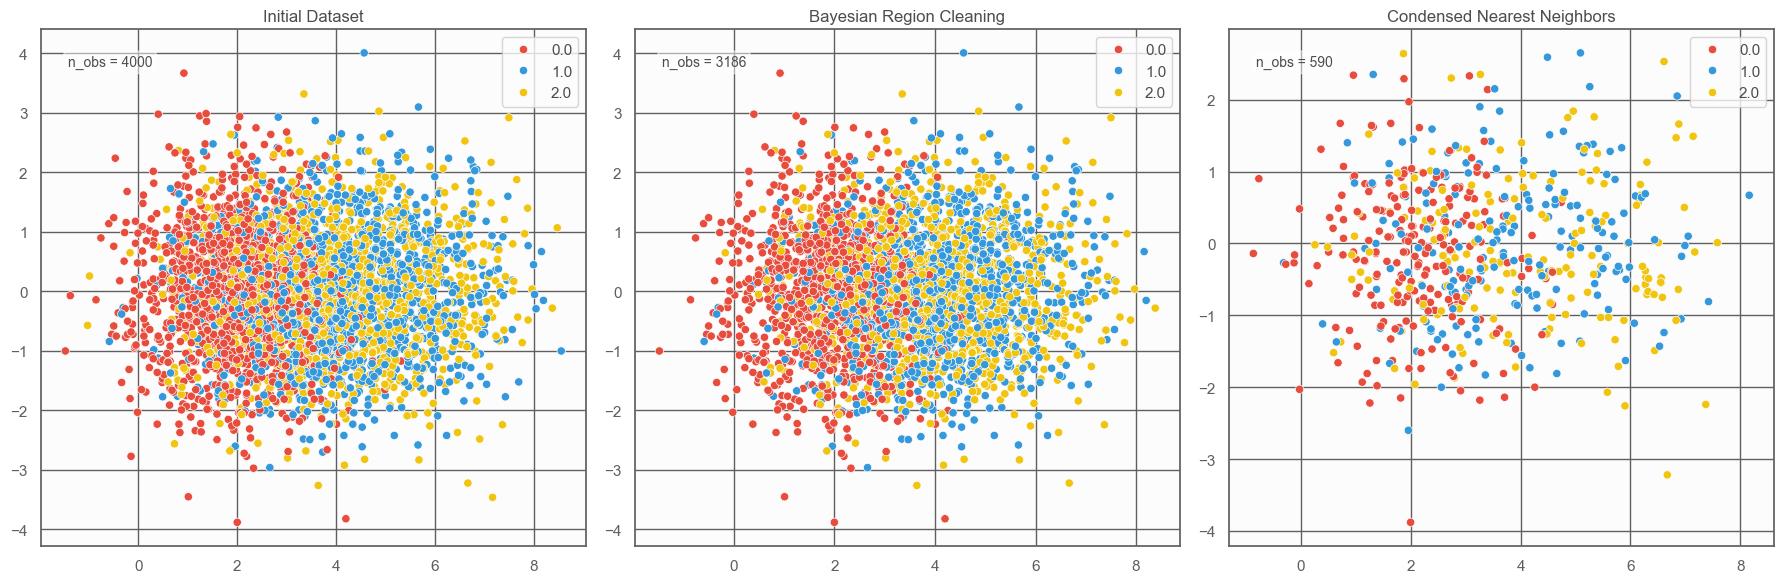

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(x=train_data[:, 10], y=train_data[:, 20], hue=train_data[:, 21], palette=palette, ax=axes[0]).set_title("Initial Dataset")
axes[0].text(
        0.05, 0.95, f"n_obs = {len(train_data[:, 10])}", 
        transform=axes[0].transAxes, 
        fontsize=10, 
        verticalalignment='top', 
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5)
    )

sns.scatterplot(x=step_one[:, 10], y=step_one[:, 20], hue=step_one[:, 21], palette=palette, ax=axes[1]).set_title("Bayesian Region Cleaning")
axes[1].text(
        0.05, 0.95, f"n_obs = {len(step_one[:, 10])}", 
        transform=axes[1].transAxes, 
        fontsize=10, 
        verticalalignment='top', 
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5)
    )

sns.scatterplot(x=step_two[:, 10], y=step_two[:, 20], hue=step_two[:, 21], palette=palette, ax=axes[2]).set_title("Condensed Nearest Neighbors")
axes[2].text(
        0.05, 0.95, f"n_obs = {len(step_two[:, 10])}", 
        transform=axes[2].transAxes, 
        fontsize=10, 
        verticalalignment='top', 
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5)
    )

plt.tight_layout()
plt.show()

We will now compare the performance of a 1KNN with our different datasets, using our 1000 samples as the test

In [14]:
accs = []
times = []

for dataset in [train_data, step_one, step_two]:
		
	calculated_distance_matrix = distance_matrix(
	dataset[:, :-1], test_data[:, :-1])

	X = dataset[:, :-1]
	y = dataset[:, -1]

	preds = []
	start_time = time.perf_counter()
	for i in range(len(test_data)):

		pred = knn(
			features_data=X,
			point_to_predict=test_data[i, :-1],
			labels_data=y,
			k=1,
			distance_matrix=calculated_distance_matrix,
			point_to_predict_index = i)
		preds.append(pred)
	end_time = time.perf_counter()
		
	acc = model_accuracy(preds, test_data[:, -1])
	accs.append(acc*100)
	times.append(end_time - start_time)

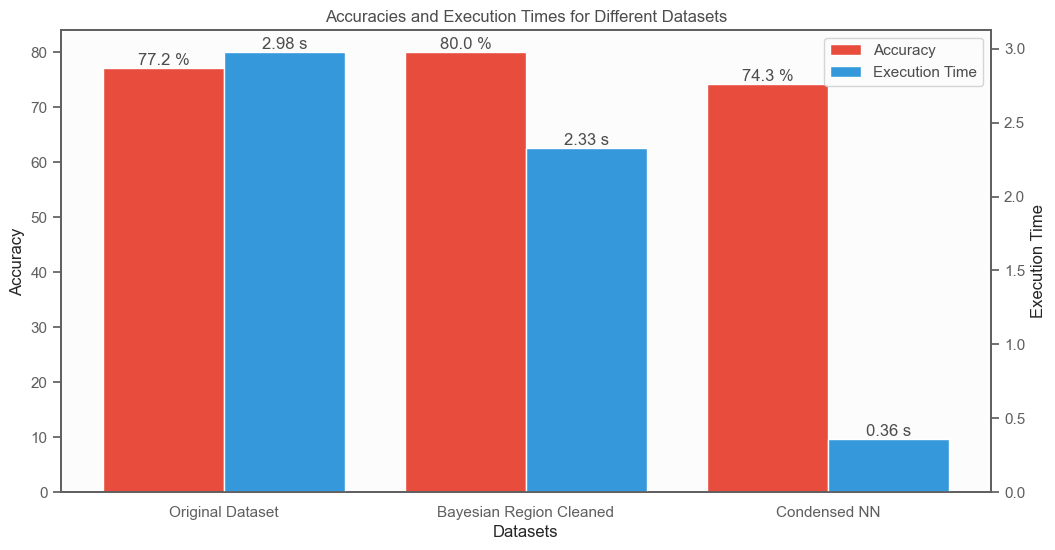

In [16]:
labels = ["Original Dataset", "Bayesian Region Cleaned", "Condensed NN"]
x = np.arange(1, len(labels)+1)  # Positions for the groups
width = 0.4  # Width of each bar

fig, ax1 = plt.subplots()

bars_acc = ax1.bar(x - width/2, accs, width, label="Accuracy", color=palette[0])
ax2 = ax1.twinx()
bars_time = ax2.bar(x + width/2, times, width, label="Execution Time", color=palette[1])

for bar in bars_acc:
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{bar.get_height():.1f} %", 
             ha="center", va="bottom")

for bar in bars_time:
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{bar.get_height():.2f} s", 
             ha="center", va="bottom")

# Add labels and title
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_xlabel("Datasets")
ax1.set_ylabel("Accuracy")
ax2.set_ylabel("Execution Time")
ax1.set_title("Accuracies and Execution Times for Different Datasets")
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2)
ax1.grid(False)
ax2.grid(False)

plt.show();

As we can see, the accuracy doesn't change too much even when we drastically reduce our dataset in the second step. The first step didn't reduce our data too much, from the initial data visualizations this was expected; there seems to be a fair amount of overlap in our classes for most of the pairs of features.